## Initial Setup

In [ ]:
## 1. Setup
!pip install transformers datasets evaluate torch scikit-learn
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 15.5 MB/s eta 0:00:00


In [ ]:
## 2. Imports
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
import evaluate
from sklearn.metrics import classification_report

## Dataset Load

In [ ]:
## 3. Data Loading & Exploration
dataset = load_dataset("naimul011/BanglaToxicCommentsDB", data_files=["bangla_comments.csv"])

# Inspect
print(dataset)
print(dataset['train'][0])

# Convert to pandas for exploration
df = pd.DataFrame(dataset['train'])
df.head()

README.md: 0.00B [00:00, ?B/s]

bangla_comments.csv:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        num_rows: 12653
    })
})
{'Unnamed: 0': 0, 'comment_text': 'ছবি টা দেখার পর বাড়া টা কেপে ওটলো😭😭😭', 'toxic': 1.0, 'severe_toxic': 1.0, 'obscene': 1.0, 'threat': 0.0, 'insult': 0.0, 'identity_hate': 0.0}


,Unnamed: 0,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,ছবি টা দেখার পর বাড়া টা কেপে ওটলো😭😭😭,1.0,1.0,1.0,0.0,0.0,0.0
1,1,পুতুলের মতো,0.0,0.0,0.0,0.0,0.0,0.0
2,2,nicher ta dekha jacche Apu 😅😅😅😅😅,1.0,1.0,1.0,0.0,0.0,0.0
3,3,ছাগলের দল ফুল ভিডিও দেখ,1.0,0.0,0.0,0.0,0.0,0.0
4,4,পুরাই আগুন 🥰🥰🥰😌,1.0,0.0,0.0,0.0,0.0,0.0


## Data exploration

Language Style Summary:
                 Count  Percentage
language_style                   
Bengali          7679       60.69
English          4954       39.15
Banglish           20        0.16


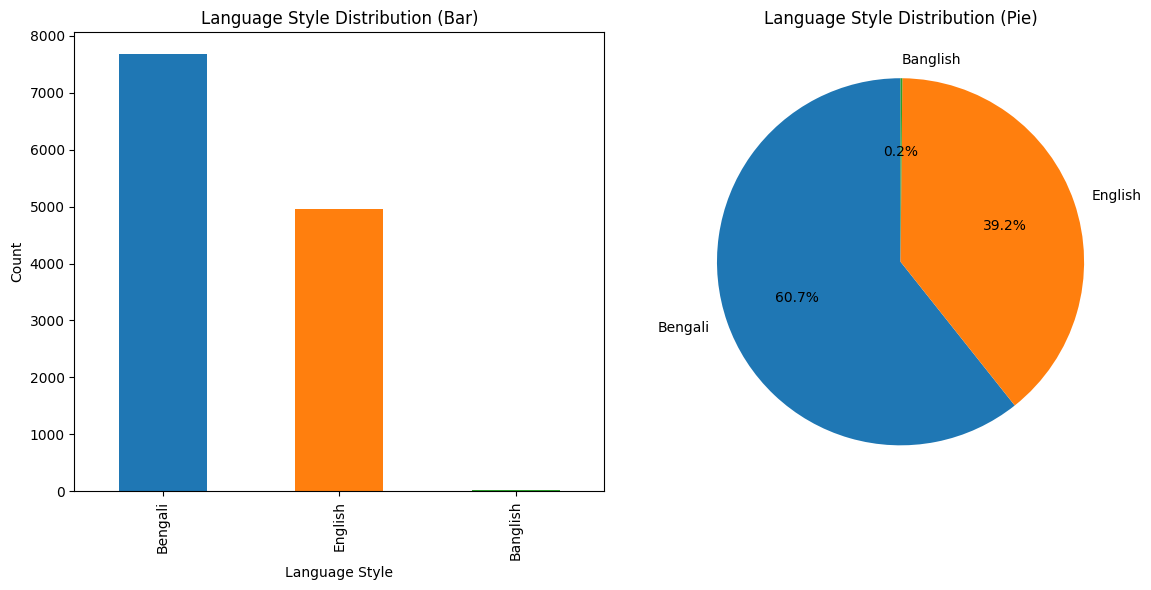

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Function to detect language style
def detect_language_style(text):
    text = str(text)
    # Bengali script check
    if re.search(r'[\u0980-\u09FF]', text):
        return "Bengali"
    # Pure English (only English chars, numbers, symbols)
    elif re.fullmatch(r'[A-Za-z0-9\s\W]+', text):
        return "English"
    # Otherwise Banglish (romanized Bangla)
    else:
        return "Banglish"

# Apply detection
df["language_style"] = df["comment_text"].apply(detect_language_style)

# Count occurrences
counts = df["language_style"].value_counts()

# Create summary DataFrame with counts + percentages
summary_df = pd.DataFrame({
    "Count": counts,
    "Percentage": (counts / counts.sum() * 100).round(2)
})

print("Language Style Summary:\n", summary_df)

# Plot bar + pie side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart
counts.plot(kind="bar", ax=axes[0], color=["#1f77b4", "#ff7f0e", "#2ca02c"])
axes[0].set_title("Language Style Distribution (Bar)")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Language Style")

# Pie chart
axes[1].pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90,
            colors=["#1f77b4", "#ff7f0e", "#2ca02c"])
axes[1].set_title("Language Style Distribution (Pie)")

plt.tight_layout()
plt.show()


## Preprocessing

### Preprocessing #01

In [ ]:
## 4. Preprocessing

# Choose a tokenizer for mBERT (first example)
model_checkpoint = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Define label columns (multi-label setup)
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Tokenization function
def preprocess(batch):
    encodings = tokenizer(batch["comment_text"], truncation=True, padding="max_length", max_length=128)
    # Handle None values in labels before converting to float
    labels = [float(batch[col]) if batch[col] is not None else 0.0 for col in label_cols]
    encodings["labels"] = labels
    return encodings

# Apply preprocessing
tokenized = dataset["train"].map(lambda x: preprocess(x), batched=False)

Map:   0%|          | 0/12653 [00:00<?, ? examples/s]

## Model & Evaluation

### mBERT with Preprocessing #01

In [ ]:
## 5. Modeling – with mBERT
num_labels = len(label_cols)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

# Define evaluation metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
    report = classification_report(labels, preds, target_names=label_cols, output_dict=True)
    # Macro F1 for comparison
    macro_f1 = report['macro avg']['f1-score']
    micro_f1 = report['weighted avg']['f1-score']
    return {"macro_f1": macro_f1, "micro_f1": micro_f1}

args = TrainingArguments(
    "mBERT-toxic-eval",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized.shuffle(seed=42).select(range(2000)),  # small subset for demo
    eval_dataset=tokenized.shuffle(seed=42).select(range(500)),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3707514274.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1
1,No log,0.395765,0.023810,0.054274
2,No log,0.359380,0.084325,0.192222


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

TrainOutput(global_step=250, training_loss=0.3878747863769531, metrics={'train_runtime': 5483.7382, 'train_samples_per_second': 0.729, 'train_steps_per_second': 0.046, 'total_flos': 263120504832000.0, 'train_loss': 0.3878747863769531, 'epoch': 2.0})

In [ ]:
# ## 6. Evaluation
# results = trainer.evaluate()
# print("Evaluation Results:", results)

# # Full classification report
# preds = trainer.predict(tokenized.shuffle(seed=42).select(range(500)))
# y_true = preds.label_ids
# probs = torch.sigmoid(torch.tensor(preds.predictions)).numpy()
# y_pred = (probs > 0.5).astype(int)

# print(classification_report(y_true, y_pred, target_names=label_cols))

## 6. Evaluation
results = trainer.evaluate()
print("Evaluation Results:", results)

# Full classification report
preds = trainer.predict(tokenized.shuffle(seed=42).select(range(500)))
y_true = preds.label_ids

# Probabilities from logits
probs = torch.sigmoid(torch.tensor(preds.predictions)).numpy()
y_pred = (probs > 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=label_cols))

# --- Extra standard metrics ---
from sklearn.metrics import accuracy_score, hamming_loss, roc_auc_score, f1_score

# Subset Accuracy (exact match)
subset_acc = accuracy_score(y_true, y_pred)
print("Subset Accuracy:", subset_acc)

# Hamming Loss
hl = hamming_loss(y_true, y_pred)
print("Hamming Loss:", hl)

# F1 Scores
f1_micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
print("F1 Score (Micro):", f1_micro)
print("F1 Score (Macro):", f1_macro)

# ROC-AUC (micro & macro)
try:
    roc_micro = roc_auc_score(y_true, probs, average="micro")
    roc_macro = roc_auc_score(y_true, probs, average="macro")
    print("ROC-AUC (Micro):", roc_micro)
    print("ROC-AUC (Macro):", roc_macro)
except Exception as e:
    print("ROC-AUC could not be calculated:", e)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Evaluation Results: {'eval_loss': 0.3593798279762268, 'eval_macro_f1': 0.08432539682539682, 'eval_micro_f1': 0.192222065991751, 'eval_runtime': 181.687, 'eval_samples_per_second': 2.752, 'eval_steps_per_second': 0.176, 'epoch': 2.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

               precision    recall  f1-score   support

        toxic       0.59      0.44      0.51       193
 severe_toxic       0.00      0.00      0.00        69
      obscene       0.00      0.00      0.00        70
       threat       0.00      0.00      0.00        17
       insult       0.00      0.00      0.00       121
identity_hate       0.00      0.00      0.00        38

    micro avg       0.59      0.17      0.26       508
    macro avg       0.10      0.07      0.08       508
 weighted avg       0.23      0.17      0.19       508
  samples avg       0.17      0.08      0.11       508

Subset Accuracy: 0.418
Hamming Loss: 0.16033333333333333
F1 Score (Micro): 0.261136712749616
F1 Score (Macro): 0.08432539682539682
ROC-AUC (Micro): 0.818758610229901
ROC-AUC (Macro): 0.7578906587986327


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

### Another model & Evaluation

In [ ]:
## 7. Comparative Experiments
Repeat **Section 5 & 6** with different models (e.g. `xlm-roberta-base`, `ai4bharat/indic-bert`, `google/muril-base-cased`, `bigscience/bloomz-560m`). Keep the same `compute_metrics` so evaluation is consistent.



SyntaxError: invalid decimal literal (ipython-input-488220466.py, line 2)

In [ ]:
## 8. Results Comparison Table
```python
# After running multiple models, log results into a DataFrame
comparison = pd.DataFrame([
    {"Model": "mBERT", "Macro F1": results["eval_macro_f1"], "Micro F1": results["eval_micro_f1"]},
    # add rows for other models
])

comparison
```

---

## 9. Conclusion & Next Steps
- Which model performs best?
- Are there trade-offs in speed vs accuracy?
- Plan how to adapt or fine-tune for Bangla specifically.


SyntaxError: invalid syntax (ipython-input-698440747.py, line 2)

In [ ]:
print(tokenized)
print(tokenized[0]['labels'])
print(type(tokenized[0]['labels']))
print(type(tokenized[0]['labels'][0]))

NameError: name 'tokenized' is not defined

## Combined Evaluation
